### 事件区域生长

In [6]:

import numpy as np
import h5py
import time

# 计算两帧特征之间的相似度（余弦相似度）
def calculate_similarity(feature1, feature2):
    dot_product = np.dot(feature1, feature2)
    norm_a = np.linalg.norm(feature1)  #L2范数，表示向量的长度
    norm_b = np.linalg.norm(feature2)
    similarity = dot_product / (norm_a * norm_b) #向量积除以向量长度的乘积等于相似度
    return similarity

# 根据相似度进行区域生长
def region_growing_event_clustering(features, similarity_threshold):
    num_frames = len(features)
    # 初始化事件标签为-1,一开始所有的帧都标记为没有归类所属事件，大小和帧数一样
    events = np.zeros(num_frames, dtype=int) - 1  
    current_event = 0  #事件的记号，依次递增表示第几个事件
    
    for i in range(num_frames):
        #如果当前帧没有标记为任何事件，防止当前帧在聚集事件之后将相邻帧也进行了标记，后续还要对相邻帧进行计算的重复开销
        if events[i] == -1:  #第一帧处理是没有事件标记的
            events[i] = current_event
            queue = [i]
            while queue:
                current_frame = queue.pop(0)
                #neighbor也只是帧索引序号，当前帧的左右相邻两帧，左右两帧进行遍历计算
                for neighbor in [current_frame - 1, current_frame + 1]:
                    #相邻帧在合理的范围内，且没有被标记为任何事件
                    if 0 <= neighbor < num_frames and events[neighbor] == -1:
                        similarity = calculate_similarity(features[current_frame], features[neighbor])
                        if similarity > similarity_threshold:
                            events[neighbor] = current_event
                            queue.append(neighbor)
            current_event += 1
    
    return events

# 主函数
def main(features, similarity_threshold):
    events = region_growing_event_clustering(features, similarity_threshold)
        # print("事件划分结果：", events)
    return events


# 示例：假设已经有视频帧特征，每个特征为长度为512的向量
# features = np.random.rand(3618, 512)  # 用随机数模拟特征
vfeat_path = '/mnt/hdd1/zhulu/mad/CLIP_B32_frames_features_5fps.h5'  #mad数据集1s采样5帧
with h5py.File(vfeat_path, 'r') as f:
    print("Keys: %s" % f.keys())
    features=f['0001_American_Beauty'][:]
# similarity_threshold = 0.75  # 根据需要调整阈值
# events=main(features, similarity_threshold)
# events

# Forrest_Gump #阿甘正传

Keys: <KeysViewHDF5 ['0001_American_Beauty', '0002_As_Good_As_It_Gets', '0003_CASABLANCA', '0004_Charade', '0005_Chinatown', '0006_Clerks', '0007_DIE_NACHT_DES_JAEGERS', '0008_Fargo', '0009_Forrest_Gump', '0010_Frau_Ohne_Gewissen', '0011_Gandhi', '0012_Get_Shorty', '0013_Halloween', '0014_Ist_das_Leben_nicht_schoen', '0016_O_Brother_Where_Art_Thou', '0017_Pianist', '0019_Pulp_Fiction', '0020_Raising_Arizona', '0021_Rear_Window', '0022_Reservoir_Dogs', '0023_THE_BUTTERFLY_EFFECT', '0026_The_Big_Fish', '0027_The_Big_Lebowski', '0028_The_Crying_Game', '0029_The_Graduate', '0030_The_Hustler', '0031_The_Lost_Weekend', '0032_The_Princess_Bride', '0033_Amadeus', '0038_Psycho', '0041_The_Sixth_Sense', '0043_Thelma_and_Luise', '0046_Chasing_Amy', '0049_Hannah_and_her_sisters', '0050_Indiana_Jones_and_the_last_crusade', '0051_Men_in_black', '0053_Rendezvous_mit_Joe_Black', '1001_Flight', '1002_Harry_Potter_and_the_Half-Blood_Prince', '1003_How_to_Lose_Friends_and_Alienate_People', '1004_Juno', '

In [282]:
from collections import Counter
def events_modify(events):
    """_summary_:将事件中出现次数低于5帧的事件进行相邻事件的合并，以避免因抖动、遮挡导致的事件划分不准确
    先统计出所有的长度低于5帧的事件(不足1s)，然后遍历这些事件，从当前事件向左找第一个长度大于5帧的事件：三种情况
    1：左边事件长度大于5帧，直接将当前事件的所有帧标记为左边事件
    2：左边事件长度小于5帧，因为是for循环遍历的方式，本身事件就是从小到大的，因此遍历到的第一个事件就是最第一个长度小于5帧的事件，不存在此情况
    3：左边没有事件，当前事件就是第一个事件，直接和1号事件进行合并（但测试集中0号事件长度都长于5帧）
    todo: 有可能0号事件和1号事件加起来也不足5帧
    Args:
        events (_type_): 事件索引，从0开始顺序递增，没有间隔

    Returns:
        _type_: 融合后的事件索引，每个事件长度大于5帧，但不保证编号连续
    """
    #统计事件中出现次数低于5的事件个数
    #统计每个元素的出现次数
    counts = Counter(events)
    require_count=5
    # 找出出现次数不超过5次的元素
    elements_with_few_occurrences = [elem for elem, count in counts.items() if count <require_count ]
    for element in elements_with_few_occurrences:  #是从所有小于5帧的元素中遍历
        # print(element)
        if counts[element]>=require_count:  #如果当前事件的长度已经大于5帧，就不需要再合并了,因为后面的操作中会改变（0号事件就不足的情况）
            continue
        events_start=np.where(events==element)[0][0]
        events_end=np.where(events==element)[0][-1]
        left_event=element+1
        for elem in range(element-1,-1,-1):
            if counts[elem]>=require_count: #也有可能一开始第0个事件就不满足5帧
                left_event=elem
                break
        if left_event==element+1: # 如果左边没有找到满足条件的事件
            left_event=element-1 #解决一开始第0个事件就不满足5帧的情况
            
        if element==0:  #第0个事件就长度不足5，但是还是可能第0个和第一个事件之和也不足5帧
            left_event=element+1 #直接替换为1号事件,因为得到的事件本身是连续的
        
        select_event=left_event  
        # 直接将events里面的元素值进行修改，后面计算IOU的时候就直接用即可
        events[events_start:events_end+1]=len(events[events_start:events_end+1])*[select_event]
        counts[select_event]+=counts[element]
        del counts[element] #删除当前元素，del 之后，该元素的值就变为0了，因此也不会在向左找的时候找到它
    return events  #一开始将return放在了for循环里面，导致只返回了最后一个元素的修改结果

##### 相似度曲线绘制

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os

video_frames = np.random.rand(1200, 512)

def similarity_curve(video_feat,movie_id):
    """_summary_:绘制相邻帧之间的相似度曲线，以便于观察相似度的变化情况

    Args:
        video_feat (_type_): 视频帧序的特征
        movie_id (_type_): ：选择的是哪个视频，用于创建该视频对应的相似度曲线图保存目录

    Returns:
        _type_: 每num_frames_per_plot帧的相似度曲线图（视频帧数太多，进行子图绘制）
    """
    # 计算两帧特征之间的相似度（余弦相似度）
    def calculate_similarity(feature1, feature2):
        dot_product = np.dot(feature1, feature2)
        norm_a = np.linalg.norm(feature1)  #L2范数，表示向量的长度
        norm_b = np.linalg.norm(feature2)
        similarity = dot_product / (norm_a * norm_b) #向量积除以向量长度的乘积等于相似度
        return similarity

    # 计算相似度,其数量和总帧数差1 
    similarities = []
    for i in range(len(video_feat) - 1):
        similarity = calculate_similarity(video_feat[i], video_feat[i + 1])
        similarities.append(similarity)

    
    # 绘制相似度曲线
    # 设置子图参数
    num_frames_per_plot = 100  #每一个子图包含多少帧的相似度曲线，为了显示更清楚
    num_subplots = len(similarities) // num_frames_per_plot + (1 if len(similarities) % num_frames_per_plot != 0 else 0)

    fig, axs = plt.subplots(num_subplots, 1, figsize=(10, num_subplots * 3))

    #判断相似度曲线图保存目录是否存在，若不存在则先创建目录
    directory_path=os.path.join("similarity_curve",movie_id)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory '{directory_path}' created.")
    else:
        print(f"Directory '{directory_path}' already exists.")
    # 绘制子图
    # 绘制子图并保存
    for i in range(num_subplots):
        fig, ax = plt.subplots(figsize=(10, 3))
        start_index = i * num_frames_per_plot
        end_index = min(start_index + num_frames_per_plot, len(similarities))
        ax.plot(range(start_index, end_index), similarities[start_index:end_index])
        ax.set_xlabel('Frame Index')
        ax.set_ylabel('Similarity')
        ax.set_xticks(range(start_index, end_index, 2))
        ax.axhline(y=0.90, color='r', linestyle='--')
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)  # 旋转x轴标签
        ax.set_title(f'Frame Similarity Curve {start_index + 1} to {end_index}')
        plt.tight_layout()

        # 保存子图
        plt.savefig(os.path.join(directory_path, f'frame_similarity_curve_{i + 1}.png'))
        plt.close(fig)

In [3]:
import json
json_path='data/mad/annotations/MAD_test.json'
with open(json_path, 'r') as f:
    data = json.load(f)


In [4]:
def get_qids(movie_id,data): #针对一个视频提取所有的query
    qids=[]
    for key,value in data.items():
        # print(value.get("movie"))
        if value.get("movie")==movie_id:
            # print(key,movie_id)
            qids.append(key)
    return qids

##### 计算聚类结果和标注query区间的IOU

In [283]:

from collections import Counter
min_iou=1
max_iou=0
def get_event_and_compute_iou(movie_id,anno_data,movie_feat):
    """整体流程为:以电影为单位,计算该电影对应的所有query的iou,只计算一次电影,节省开销
    Args:
        q_id (string): 为查询的编号
        events: 为对应的视频的事件标签

    Returns:
        list: 与事件的iou
    """
    global min_iou, max_iou  # 声明全局变量
    frame_rate=5
    qids=get_qids(movie_id,anno_data)
    ious=[]
    if qids: #因为使用的是不同的数据分割标注,不一定包含该视频
        #计算一次视频的事件即可
        similarity_threshold=0.9
        events=region_growing_event_clustering(movie_feat, similarity_threshold)
        events=events_modify(events)
        
        require_count=5
        counts=Counter(events)
        # 找出出现次数不超过5次的元素
        elements_with_few_occurrences = [elem for elem, count in counts.items() if count <require_count ]
        if len(elements_with_few_occurrences)>0:
            print("modify fail")
            print(elements_with_few_occurrences)
        
        for q_id in qids: #计算该视频的所有query的timestamps的iou
            # print(q_id)
            start_time,end_time=data[q_id]["timestamps"] #得到的是绝对时间戳
            movie_id=data[q_id]["movie"]
            start_index=round(start_time*frame_rate) #得到绝对帧索引
            end_index=round(end_time*frame_rate)
            #找到了此query对应的帧特征索引之后,要去匹配最接近的事件区间
            nearest_event=events[start_index:end_index+1]  #events和特征帧数是一样的
            #统计事件区间中出现次数最多的事件,作为该query匹配的事件
            counter = Counter(nearest_event)
            main_event = counter.most_common(1)[0][0]
            
            # print("main_event,query: ",main_event,anno_data[q_id]["sentence"])
            #根据主事件来得到交并比
            event_start_index=np.where(events==main_event)[0][0]
            event_end_index=np.where(events==main_event)[0][-1]
            event_start_time=event_start_index/frame_rate
            event_end_time=event_end_index/frame_rate
            iou=(min(end_time,event_end_time)-max(start_time,event_start_time))/(max(end_time,event_end_time)-min(start_time,event_start_time))
            if iou<0:
                iou=1e-5  #当作一个比较小的数
            ious.append(iou)
            if iou>max_iou:
                max_iou=iou
            if iou<min_iou:
                min_iou=iou
    return ious

In [286]:
import h5py
vfeat_path = '/mnt/hdd1/zhulu/mad/CLIP_B32_frames_features_5fps.h5'  #mad数据集1s采样5帧
movie_ious=dict()
with h5py.File(vfeat_path, 'r') as f:
    for key in f.keys():
        movie_id=key
        movie_feat=f[key][:]
        ious=get_event_and_compute_iou(movie_id,data,movie_feat)
        if ious:
            # movie_ious.append(sum(ious)/len(ious)) 
            movie_ious[movie_id]=sum(ious)/len(ious)

modify fail
[-1]


In [287]:
 #这个iou计算过程可能有问题，不应该会出现负数，
 #本身计算的时候就是根据真实区间对应的帧索引中去找到事件，肯定是有iou相交的不应该为负数
# min_iou,max_iou 
ious=movie_ious.values()
max(ious),min(ious),sum(ious)/len(ious),min_iou,max_iou

(0.5637360146774332, 0.11537377141697054, 0.4475836703010466, 1e-05, 1.0)

In [296]:
import h5py
import json
json_path='data/mad/annotations/MAD_test.json'
with open(json_path, 'r') as f:
    data = json.load(f)
vfeat_path = '/mnt/hdd1/zhulu/mad/CLIP_B32_frames_features_5fps.h5'  #mad数据集1s采样5帧
f = h5py.File(vfeat_path, 'r')
movie_id="1012_Unbreakable"
movie_feat=f[movie_id][:]
ious=get_event_and_compute_iou(movie_id,data,movie_feat)  #modify只执行了一个数就退出了
sum(ious)/len(ious),len(ious)
# similarity_curve(f[movie_id][:],movie_id)
f.close()

In [297]:
sum(ious)/len(ious),len(ious)

(0.28322061788559505, 577)

In [309]:

similarity_threshold=0.9
events=region_growing_event_clustering(movie_feat, similarity_threshold)
events=events_modify(events)
# first_60_index = np.where(events == 1)
# first_60_index[0][-1],first_60_index[0][0]
# events[9255:9400],first_60_index[0][0],first_60_index[0][-1]

##### 统计事件的区间长度

[7, 6, 2, 10, 4, 5, 17, 8, 13, 59, 3, 20, 11, 21, 24, 23, 18, 28, 35, 45, 30, 50, 14, 54, 9, 37, 97, 12, 113, 19, 15, 1, 63, 42, 25, 62, 34, 31, 32, 58, 112, 100, 27, 33, 16, 64, 114, 22, 109, 26, 47, 39, 174, 65, 72, 29, 67, 92, 56, 57]


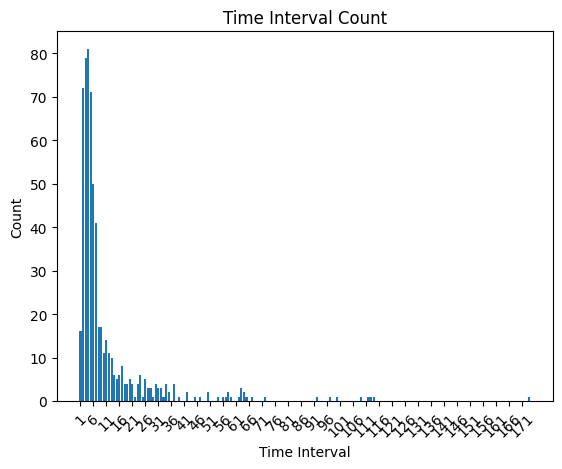

In [318]:
import matplotlib.pyplot as plt
import math
from collections import Counter

similarity_threshold=0.9
events=region_growing_event_clustering(movie_feat, similarity_threshold)
events=events_modify(events)
counts=Counter(events)
time_interval=dict()
for key,value in counts.items():
    time_span=math.ceil(value/5)  #帧数转换为时间s数
    if time_span not in time_interval:
        time_interval[time_span]=1
    else:
        time_interval[time_span]+=1


# Extract the keys and values from the dictionary
keys = list(time_interval.keys())
values = list(time_interval.values())
print(keys)
# Plot the data
plt.bar(keys, values)
plt.xticks(ticks=range(min(keys), max(keys) + 1, 5))
plt.xticks(rotation=45)
plt.xlabel('Time Interval')
plt.ylabel('Count')
plt.title('Time Interval Count')
# Display the plot
plt.savefig("time_interval.png")  #应该在show之前调用savefig，show之后会清空当前图
plt.show()


In [230]:
for i in range(0,0,-1):
    print(i)

In [237]:
require_count=5
# 找出出现次数不超过5次的元素
elements_with_few_occurrences = [elem for elem, count in counts.items() if count <require_count ]
elements_with_few_occurrences[:3]

[]

In [243]:
import json

events
counts = Counter(events)
counts
# Convert counts to a dictionary
# counts_dict = dict(counts)
# counts_dict = {str(k): v for k, v in counts.items()}
# # Write counts to a JSON file
# with open('counts.json', 'w') as f:
#     json.dump(counts_dict, f)

Counter({0: 33,
         3: 29,
         4: 6,
         5: 49,
         7: 10,
         8: 18,
         9: 22,
         10: 82,
         12: 29,
         13: 19,
         15: 36,
         17: 65,
         18: 292,
         22: 15,
         25: 49,
         26: 96,
         27: 27,
         28: 23,
         29: 16,
         30: 18,
         32: 16,
         34: 16,
         35: 21,
         36: 12,
         37: 20,
         38: 17,
         39: 22,
         40: 12,
         41: 47,
         43: 18,
         44: 22,
         45: 21,
         46: 55,
         48: 24,
         49: 50,
         52: 18,
         53: 19,
         54: 103,
         56: 18,
         58: 16,
         59: 36,
         60: 23,
         61: 9,
         64: 33,
         66: 22,
         68: 10,
         69: 118,
         71: 111,
         72: 23,
         73: 89,
         75: 117,
         76: 19,
         77: 98,
         79: 24,
         81: 32,
         83: 22,
         85: 21,
         86: 24,
         87: 11,
 

In [ ]:
events
counts = Counter(events)
# 找出出现次数不超过5次的元素
elements_with_few_occurrences = [elem for elem, count in counts.items() if count <= 5]
elements_with_few_occurrences

In [160]:
x=[0,1,2,3,4,5,6,7]
x[0:4]=[3]*len(x[0:4])
x,len(x[0:4])

([3, 3, 3, 3, 4, 5, 6, 7], 4)

In [102]:
vfeat_path = '/mnt/hdd1/zhulu/mad/CLIP_B32_frames_features_5fps.h5'  #mad数据集1s采样5帧
f = h5py.File(vfeat_path, 'r')
movie_id="1012_Unbreakable"
Mfeats=f[movie_id][:]
feature1=Mfeats[3830]
feature2=Mfeats[3831]
dot_product = np.dot(feature1, feature2)
norm_a = np.linalg.norm(feature1)  #L2范数，表示向量的长度
norm_b = np.linalg.norm(feature2)
similarity = dot_product / (norm_a * norm_b) #向量积除以向量长度的乘积等于相似度
similarity

0.82389915

In [53]:
import json

# Write the dictionary to a file
with open('movie_ious.json', 'w') as f:
    json.dump(movie_ious, f)

### Event class loss

###### `输入`：1：一维向量，值单调不减，表示属于第几个事件，索引表示是视频中的第几帧；2：N表示需要对齐到多少帧（多于N帧，进行下采样，少于N帧不处理）
###### `输出`：

In [2]:
import torch

def resample_event_indices(indices, N):
    num_frames = len(indices)
    #短事件进行补齐
    # if num_frames < N:
    #     # 循环重复补齐帧数
    #     repeat_times = N // num_frames
    #     remainder = N % num_frames
    #     resampled_indices = indices.repeat(repeat_times)
    #     if remainder > 0:
    #         resampled_indices = torch.cat((resampled_indices, indices[:remainder]))
    if num_frames > N:
        # 随机下采样
        resampled_indices = indices[torch.randperm(num_frames)[:N]]
    else:
        resampled_indices = indices
    return resampled_indices

def align_event_frames(events, N):
    unique_events = torch.unique(events)
    event_to_indices = {event.item(): (events == event).nonzero(as_tuple=True)[0] for event in unique_events}

    # 对每个事件的帧索引进行对齐，并保留对齐后的索引信息
    aligned_indices = []
    for event, indices in event_to_indices.items():
        resampled_indices = resample_event_indices(indices, N)
        aligned_indices.append(resampled_indices)

    # 将对齐后的索引展平，并按帧索引排序
    aligned_indices = torch.cat(aligned_indices)

    # 创建一个新的事件数组，大小与对齐后的索引一致
    aligned_events = torch.zeros(len(aligned_indices), dtype=events.dtype)
    for new_index, old_index in enumerate(aligned_indices):
        aligned_events[new_index] = events[old_index]

    return aligned_events, aligned_indices

# 示例用法
if __name__ == "__main__":
    # 示例输入
    events = torch.tensor([0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4])  # 事件编号数组
    N = 5  # 目标帧数

    aligned_events, aligned_indices = align_event_frames(events, N)
    print("Aligned events:", aligned_events)
    print("Aligned indices:", aligned_indices)

Aligned events: tensor([0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4])
Aligned indices: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10,  9, 14, 13, 11, 16, 21, 17, 20,
        19])


22

###### `损失`:事件内帧相似度高，事件间帧相似度低

In [62]:
import torch
import torch.nn.functional as F

def get_event_representatives(feats, events):
    unique_events = torch.unique(events)  
    start_feats = []
    mean_feats = []
    end_feats = []

    for event in unique_events:
        #返回各个事件的所包含的索引位置
        event_indices = (events == event).nonzero(as_tuple=True)[0]
        if len(event_indices) > 0:
            # print("shape: ",feats[event_indices[0]].unsqueeze(0).shape)
            start_feats.append(feats[event_indices[0]].unsqueeze(0)) #（1，512）
            end_feats.append(feats[event_indices[-1]].unsqueeze(0))
            mean_feats.append(feats[event_indices].mean(dim=0).unsqueeze(0))
    
    return torch.cat(start_feats), torch.cat(mean_feats), torch.cat(end_feats)

def calculate_similarity_loss(feats, events):
    #start_feats表示每个事件的第一帧特征，mean_feats表示每个事件的平均特征，
    #end_feats表示每个事件的最后一帧特征，向量长度表示事件个数
    start_feats, mean_feats, end_feats = get_event_representatives(feats, events)
    # print("start_feats: ", start_feats.shape)
    
    # Same event similarity (maximize)
    same_event_loss = 0.0
    print("simi: ",F.cosine_similarity(start_feats, mean_feats).shape)
    #是两个张量之间每行元素进行对应，每一行表示一个事件，因此计算等价于
    #第一个事件的开始特征和第一个事件的平均特征的余弦相似度
    same_event_loss += torch.sum(1 - F.cosine_similarity(start_feats, mean_feats))
    same_event_loss += torch.sum(1 - F.cosine_similarity(mean_feats, end_feats))
    same_event_loss += torch.sum(1 - F.cosine_similarity(start_feats, end_feats))
    
    # Adjacent event dissimilarity (minimize similarity)
    adjacent_event_loss = 0.0

    # Calculate cosine similarity for adjacent events
    for i in range(start_feats.shape[0] - 1):
        #虽然没有显示计算当前事件和前一个事件之间关于三个代表帧之间的相似度，但是通过累加计算步骤
        #能够隐含的实现该功能
        current_start, current_mean, current_end = start_feats[i], mean_feats[i], end_feats[i]
        next_start, next_mean, next_end = start_feats[i + 1], mean_feats[i + 1], end_feats[i + 1]

        # Concatenate all current and next features
        current_feats = torch.cat((current_start.unsqueeze(0), current_mean.unsqueeze(0), current_end.unsqueeze(0)))
        next_feats = torch.cat((next_start.unsqueeze(0), next_mean.unsqueeze(0), next_end.unsqueeze(0)))

        # Calculate cosine similarity between all pairs of current and next features
        similarity_matrix = F.cosine_similarity(current_feats.unsqueeze(1), next_feats.unsqueeze(0), dim=2)
        
        adjacent_event_loss -= similarity_matrix.sum()

    total_loss = same_event_loss + adjacent_event_loss
    return total_loss

# 示例用法
if __name__ == "__main__":
    # 示例输入
    events = torch.tensor([0, 0, 0, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4])
    feats = torch.randn(len(events), 512)

    loss = calculate_similarity_loss(feats, events)
    print("Loss:", loss.item())

simi:  torch.Size([5])
Loss: 9.615434646606445


###### `抽象事件表达`:将上述得到的长度不一的事件单元进行抽象表示，以统一每个事件的维度。
###### （如：有的短事件仅包含5帧，但有的长事件包含100帧，为了便于后续的批量计算，将每个事件的维度进行对齐，全部变为【N,M】，其中N表示抽象的概念，不同的事件虽然帧数不同，但是都需要人物、物品、动作、环境等）
###### 用attention计算，设置可学习的query数量为num_queries，这些query与事件交互，得到抽象语义信息

In [2]:
import torch
import torch.nn.functional as F

class AttentionModule(torch.nn.Module):
    def __init__(self, num_queries, input_dim):
        super(AttentionModule, self).__init__()
        self.num_queries = num_queries
        self.input_dim = input_dim
        
        # 定义查询向量
        self.queries = torch.nn.Parameter(torch.randn(num_queries, input_dim))
        
        # 线性层，将帧特征映射到注意力分数
        self.linear = torch.nn.Linear(input_dim, 1)
        
    def forward(self, event_unit):
        # event_unit 的维度应为 (num_frames, input_dim)
        num_frames = event_unit.size(0)
        
        # 计算查询向量与帧特征的注意力分数
        # queries(num_queries,hidden dim) event_unit(num_frames,hidden dim) -> (num_queries,num_frames)
        query_scores = torch.matmul(self.queries, event_unit.T) 
        
        # 计算注意力权重
        # 每一行上进行 softmax，得到每个查询对每帧的注意力权重(合理)
        weights = F.softmax(query_scores, dim=1) # 在每个查询向量的维度上进行 softmax
        
        # 加权平均每帧的特征，得到每个查询的抽象特征
        #weights(num_queries,num_frames) event_unit(num_frames,hidden dim) -> (num_queries,hidden
        attended_features = torch.matmul(weights, event_unit)  # (num_queries, input_dim)
        
        # 返回结果
        return attended_features

# 示例用法
input_dim = 512
num_queries = 15  # 事件中抽象概念的学习，比如人物、动作、场景、动作等

# 创建注意力模块实例
attention_module = AttentionModule(num_queries, input_dim)

# 生成示例数据，假设事件单元有100帧，每帧特征为512维
event_unit = torch.randn(119, input_dim)
# 虽然可以处理不同帧长的事件序列，都编码成15，512，但是不能一次性批量计算，在pytorch中tensor张量要保持矩阵格式
# 因此可能还是需要按长度分批处理，这种方式会打乱顺序，可能需要对原本的索引进行一定的保存

# 使用注意力模块进行前向传播
abstract_features = attention_module(event_unit)

# 打印结果形状，预期输出形状为 (num_queries, input_dim)
print("Abstract features shape:", abstract_features.shape)


Abstract features shape: torch.Size([15, 512])


##### 采样器

In [4]:
from torch.utils.data.distributed import DistributedSampler
import math
from typing import TypeVar, Optional, Iterator
from torch.utils.data import Sampler, Dataset
import torch
import torch.distributed as dist
T_co = TypeVar('T_co', covariant=True)

class MyDistributedSampler(Sampler[T_co]):
    r"""
    Args:
        dataset: Dataset used for sampling.
        num_replicas (int, optional): Number of processes participating in
            distributed training. By default, :attr:`world_size` is retrieved from the
            current distributed group. 表示num_replicas等价于world_size
        rank (int, optional): Rank of the current process within :attr:`num_replicas`.
            By default, :attr:`rank` is retrieved from the current distributed
            group.
        shuffle (bool, optional): If ``True`` (default), sampler will shuffle the
            indices.
        seed (int, optional): random seed used to shuffle the sampler if
            :attr:`shuffle=True`. This number should be identical across all
            processes in the distributed group. Default: ``0``.
        drop_last (bool, optional): if ``True``, then the sampler will drop the
            tail of the data to make it evenly divisible across the number of
            replicas. If ``False``, the sampler will add extra indices to make
            the data evenly divisible across the replicas. Default: ``False``.

    .. warning::
        In distributed mode, calling the :meth:`set_epoch` method at
        the beginning of each epoch **before** creating the :class:`DataLoader` iterator
        is necessary to make shuffling work properly across multiple epochs. Otherwise,
        the same ordering will be always used.

    Example::

        >>> # xdoctest: +SKIP
        >>> sampler = DistributedSampler(dataset) if is_distributed else None
        >>> loader = DataLoader(dataset, shuffle=(sampler is None),
        ...                     sampler=sampler)
        >>> for epoch in range(start_epoch, n_epochs):
        ...     if is_distributed:
        ...         sampler.set_epoch(epoch)
        ...     train(loader)
    """

    def __init__(self, dataset: Dataset, num_replicas: Optional[int] = None,
                 rank: Optional[int] = None, shuffle: bool = True,
                 seed: int = 0, drop_last: bool = False) -> None:
        if num_replicas is None:
            if not dist.is_available():
                raise RuntimeError("Requires distributed package to be available")
            num_replicas = dist.get_world_size()
        if rank is None:
            if not dist.is_available():
                raise RuntimeError("Requires distributed package to be available")
            rank = dist.get_rank()
        if rank >= num_replicas or rank < 0:
            raise ValueError(
                "Invalid rank {}, rank should be in the interval"
                " [0, {}]".format(rank, num_replicas - 1))
        self.dataset = dataset
        self.num_replicas = num_replicas
        self.rank = rank
        self.epoch = 0
        self.drop_last = drop_last
        # If the dataset length is evenly divisible by # of replicas, then there
        # is no need to drop any data, since the dataset will be split equally.
        if self.drop_last and len(self.dataset) % self.num_replicas != 0:  # type: ignore[arg-type]
            
            self.num_samples = math.ceil(
                (len(self.dataset) - self.num_replicas) / self.num_replicas  # type: ignore[arg-type]
            )
        else: #不需要丢弃数据，使用全部数据
            self.num_samples = math.ceil(len(self.dataset) / self.num_replicas)  
        self.total_size = self.num_samples * self.num_replicas #在不丢弃数据的情况下，total_size在不整除的情况下会变大
        self.shuffle = shuffle
        self.seed = seed

    def __iter__(self) -> Iterator[T_co]:
        if self.shuffle:
            # deterministically shuffle based on epoch and seed
            g = torch.Generator() #创造一个随机数生成器
            g.manual_seed(self.seed + self.epoch)
            indices = torch.randperm(len(self.dataset), generator=g).tolist()  # type: ignore[arg-type]
        else:
            indices = list(range(len(self.dataset)))  # type: ignore[arg-type]

        if not self.drop_last:  #表示要使用所有的数据
            # add extra samples to make it evenly divisible
            padding_size = self.total_size - len(indices)
            if padding_size <= len(indices):
                indices += indices[:padding_size]
            else:
                indices += (indices * math.ceil(padding_size / len(indices)))[:padding_size]
        else:
            # remove tail of data to make it evenly divisible.
            indices = indices[:self.total_size]
        assert len(indices) == self.total_size
        #上述实现对数据丢弃与否的处理

        # subsample
        indices = indices[self.rank:self.total_size:self.num_replicas]
        assert len(indices) == self.num_samples

        return iter(indices)

    def __len__(self) -> int:
        return self.num_samples
    


    def set_epoch(self, epoch: int) -> None:
        r"""
        Sets the epoch for this sampler. When :attr:`shuffle=True`, this ensures all replicas
        use a different random ordering for each epoch. Otherwise, the next iteration of this
        sampler will yield the same ordering.

        Args:
            epoch (int): Epoch number.
        """
        self.epoch = epoch



In [ ]:
from torch.utils.data import Dataset, DataLoader
# 自定义数据集示例
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
data = list(range(100))
dataset = CustomDataset(data)

# 初始化 DistributedSampler
sampler = MyDistributedSampler(dataset)

# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

# 使用 DataLoader 进行训练或评估
for batch in dataloader:
    # 在这里添加训练或评估逻辑
    print(batch)


In [2]:
import math
math.ceil(10 / 3)

4

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler

# 自定义数据集示例
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

# 自定义 DistributedSampler
class MyDistributedSampler(DistributedSampler):
    def __init__(self, dataset, num_replicas=None, rank=None, shuffle=True):
        super().__init__(dataset, num_replicas=num_replicas, rank=rank, shuffle=shuffle)
        # 在这里可以添加自定义的初始化逻辑

    def __iter__(self):
        # 这里可以自定义采样器的迭代逻辑，例如修改采样的顺序等
        indices = list(super().__iter__())
        # 可以在这里加入自己的采样逻辑，比如重新排序
        return iter(indices)

# 示例用法
if __name__ == "__main__":
    # 创建自定义数据集
    data = list(range(100))
    dataset = CustomDataset(data)

    # 初始化 DistributedSampler
    sampler = MyDistributedSampler(dataset)

    # 创建 DataLoader
    dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)

    # 使用 DataLoader 进行训练或评估
    for batch in dataloader:
        # 在这里添加训练或评估逻辑
        print(batch)


##### 聚类